## Scanning an image

### Loading the model

To scan an image and predict the resulting images, it has to be cut into chunks which are of size 32x32 to fit into the model which was trained in the Student Research Project (srp) in this [repository](https://github.com/klawr/deepmech).

The respecive model is given as:

In [1]:
from os import path

import tensorflow as tf

model_path = path.join('models', 'symbol_classifier','model.h5')
model = tf.keras.models.load_model(model_path)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 14,643
Trainable params: 14,643
Non-trainable params: 0
____________________________________________________

## Loading the image

The following image, loaded with `cv2`, serves as a test image:

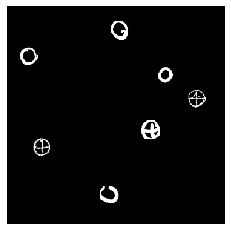

In [2]:
import cv2
from matplotlib import pyplot as plt

image_path = path.join('reports', 'sep', 'images', 'node_localization.png')

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.axis('off')
plt.set_cmap('gray')
plt.imshow(image)
plt.show()

## Image cropping

This image (360x360) is now cut into 108.241 ($h + 1 - 32 * w + 1 - 32$) 32x32 images, which can be fed into the model.


In [3]:
s = 360 + 1 - 32

image_exp = tf.expand_dims(tf.expand_dims(image, axis=-1), axis=0)
image_exp = tf.cast(image_exp / 255, tf.float32)
boxes = [[i, j, (i + 32), (j + 32)] for i in range(s) for j in range(s)]
boxes = tf.constant(boxes, tf.float32) / 360
box_indices = tf.zeros(len(boxes), dtype=tf.int32)
crop_size = (32, 32)

crops = tf.image.crop_and_resize(image_exp, boxes, box_indices, crop_size)

crops.shape

TensorShape([108241, 32, 32, 1])

## Checking the input data

A selection of crops (which assemble to represent the input image) are loaded here, to confirm successfull cropping.

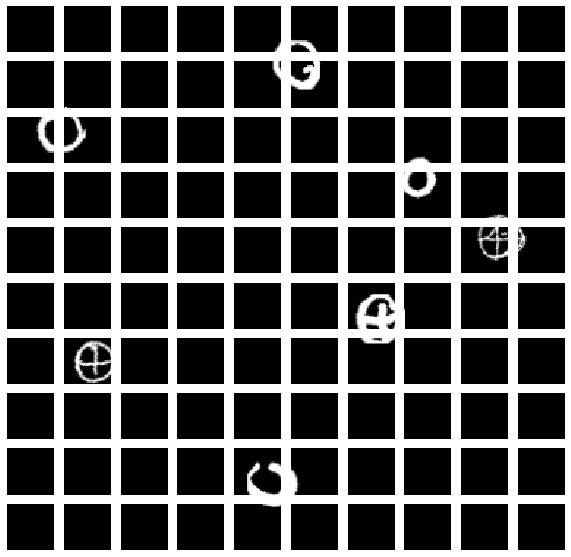

In [4]:
crops_2d = tf.reshape(crops, (s,s,32,32,1))

plt.figure(figsize=(10,10))

for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        x = i * 36
        y = j * 36
        plt.imshow(tf.squeeze(crops_2d[x][y]))

plt.show()

## Taking the time

Now a prediction is made for each crop.

The time is stopped to be able to compare it later on with other approaches, as it is essential to minimize the processing time.

5 predictions are printed to confirm the crops are predicted accordingly.
We expect 5 times the same prediction, since the images are all the same in the upper right corner for the 5 first crops and they should have the highest value on their first parameter.

```
Please note: These predictions are made on a CPU.
```

In [5]:
from time import time
start = time()
predictions = model.predict(crops)
duration = time() - start

print("Finished after", round(duration, 2), "seconds.")
print("")
print(predictions[:5])

Finished after 16.58 seconds.

[[0.7991206  0.05116128 0.14971817]
 [0.7991206  0.05116128 0.14971817]
 [0.7991206  0.05116128 0.14971817]
 [0.7991206  0.05116128 0.14971817]
 [0.7991206  0.05116128 0.14971817]]


## Draw bounding boxes

The predictions can be mapped onto the input image to show where the algorithm detected which symbols.

`predictions` is an array, whereas the max value of a value indicates the index of the corresponing label of the original `n`, `o`, `x` mapping (in that order).

`node_idx` and `base_idx` are mapped accordingly by filtering the `max_idx` by `1` or `2` (`o` or `x`).

Bounding boxes are mapped using the position of the prediction and then normalizing it in `get_bounding_boxes`.

The image has to be converted to `rgb`, because the bounding boxes should be drawn in colors.

They are then mapped using tensorflows `tf.image.draw_bounding_boxes`.

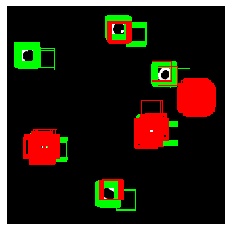

In [6]:
max_idx = tf.math.argmax(predictions, -1)
max_idx_2d = tf.reshape(max_idx, (s, s))

node_idx = tf.where(tf.equal(max_idx_2d, 1))
base_idx = tf.where(tf.equal(max_idx_2d, 2))

def get_bounding_boxes(indices):
    y, x = tf.split(indices, 2, -1)
    coords = tf.stack([y, x, y + 32, x + 32], -1)
    coords = tf.squeeze(coords)
    coords = tf.cast(coords / 360, tf.float32)

    return tf.expand_dims(coords, 0)

node_boxes = get_bounding_boxes(node_idx)
base_boxes = get_bounding_boxes(base_idx)

image_rgb = tf.image.grayscale_to_rgb(image_exp)
image_boxes = tf.image.draw_bounding_boxes(image_rgb, node_boxes, [[0, 1, 0]])
image_boxes = tf.image.draw_bounding_boxes(image_boxes, base_boxes, [[1, 0, 0]])


plt.axis('off')
plt.set_cmap('hsv')
plt.imshow(tf.squeeze(image_boxes))
plt.show()

## Non max suppression

The predictions overlap each other on various occasions.
Due to the number of almost similar images a lot of false predictions are made.

To filter these images a [`non max suppression`](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) algorithm is used, which calculates the intersection over union of two boxes and keeps the one with the higher score.

For this the `max_val` is determined and transformed into a 2d format (similar to the index previously).

`non max suppression` has to be made on all boxes at once to be able to compare boxes of different classes.
For this `node_idx` and `base_idx` are concatenated and then filtered by `tf.image.non_max_suppression`.

Since `node_idx` and `base_idx` are concatenated, all indices greater than `node_idx.shape[0]` are `base_idx` and using this a `boolean_mask` is created to filter `node_boxes` and `base_boxes`.

Bounding boxes are then drawn and the expected effect is a much cleaner output image.

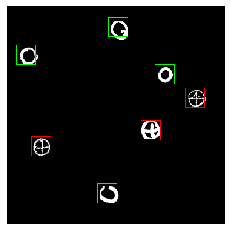

In [7]:
max_val = tf.math.reduce_max(predictions, -1)
max_val_2d = tf.reshape(max_val, (s, s))

all_idx = tf.concat([node_idx, base_idx], 0)
all_boxes = tf.squeeze(get_bounding_boxes(all_idx))
scores = tf.gather_nd(max_val_2d, all_idx)
eps = tf.keras.backend.epsilon()
nms_idx = tf.image.non_max_suppression(all_boxes, scores, 99, eps, 0.5)

mask = tf.less(nms_idx, node_idx.shape[0])
node_mask = tf.boolean_mask(nms_idx, mask)
base_mask = tf.boolean_mask(nms_idx,~mask)

node_boxes = tf.gather(all_boxes, node_mask)
base_boxes = tf.gather(all_boxes, base_mask)

image_nms = tf.image.draw_bounding_boxes(image_rgb, [node_boxes], [[0, 1, 0]])
image_nms = tf.image.draw_bounding_boxes(image_nms, [base_boxes], [[1, 0, 0]])

plt.axis('off')
plt.set_cmap('gray')
plt.imshow(tf.squeeze(image_nms))
plt.show()


## Duration:

In [8]:
print(round(duration, 2), 'seconds.')

16.58 seconds.
